# Digit Classifier

In this playbook, you can generate and train a model that can classify between 10 different classes. These classes are the digits. If you want you can classify between any two class of digits or other multi-class classificaiton.

## Import Libraries

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from torchmetrics import ConfusionMatrix

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

from torch.autograd import Variable

from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

## Explore and Import the Data

Import dataframes seperatley, then merge and shuffle them

In [14]:
# 28x28 pixels image, has first 2 columns as ImageId and label respectively
_train = pd.read_csv('./train.csv')
_test = pd.read_csv('./test_labeled.csv', sep=';')

In [15]:
def extract_DF(df, label):
    temp = df.loc[df['label'] < label+1]
    return temp.loc[temp['label'] > label-1]

In [16]:
# test datasets

class1 = 6
class2 = 8
a1 = extract_DF(_train, class1)
a2 = extract_DF(_train, class2)

train_df = pd.concat([a1, a2])
train_df = train_df.sample(frac=1).reset_index(drop=True)

# train datasets
e1 = extract_DF(_test, class1)
e2 = extract_DF(_test, class2)

test_df = pd.concat([e1, e2])
test_df = test_df.sample(frac=1).reset_index(drop=True)

Here print the first 10 rows of these datasets to verify that they are corectly generated

In [17]:
print("Train:", train_df.iloc[:10,0])
print("Test:", test_df.iloc[:10,0])

Train: 0    8
1    6
2    6
3    6
4    8
5    8
6    6
7    8
8    6
9    6
Name: label, dtype: int64
Test: 0    8
1    6
2    8
3    8
4    6
5    6
6    8
7    8
8    8
9    6
Name: label, dtype: int64


In [18]:
# 28x28 pixels image, has first 2 columns as ImageId and label respectively

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print("Number of training samples:",n_train)
print('Number of training pixels: ', n_pixels)
print('Number of classes: ', n_class)

Number of training samples: 8200
Number of training pixels:  784
Number of classes:  2


In [19]:
# 28x28 pixels image, has first 2 columns as ImageId and label respectively

n_test = len(test_df)
n_pixels = len(test_df.columns) - 1
n_class = len(set(test_df['label']))

print("Number of training samples:",n_test)
print('Number of training pixels: ', n_pixels)
print('Number of classes: ', n_class)

Number of training samples: 5368
Number of training pixels:  784
Number of classes:  2


## Display Some Images

In [20]:
def dispImage(df, im):
    grid = make_grid(torch.Tensor((df.iloc[im, 1:].to_numpy()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=7)
    plt.rcParams['figure.figsize'] = (32, 150)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.axis('off')

6, 6, 8, 8, 6, 8, 8, 8, 8, 8, 6, 8, 8, 6


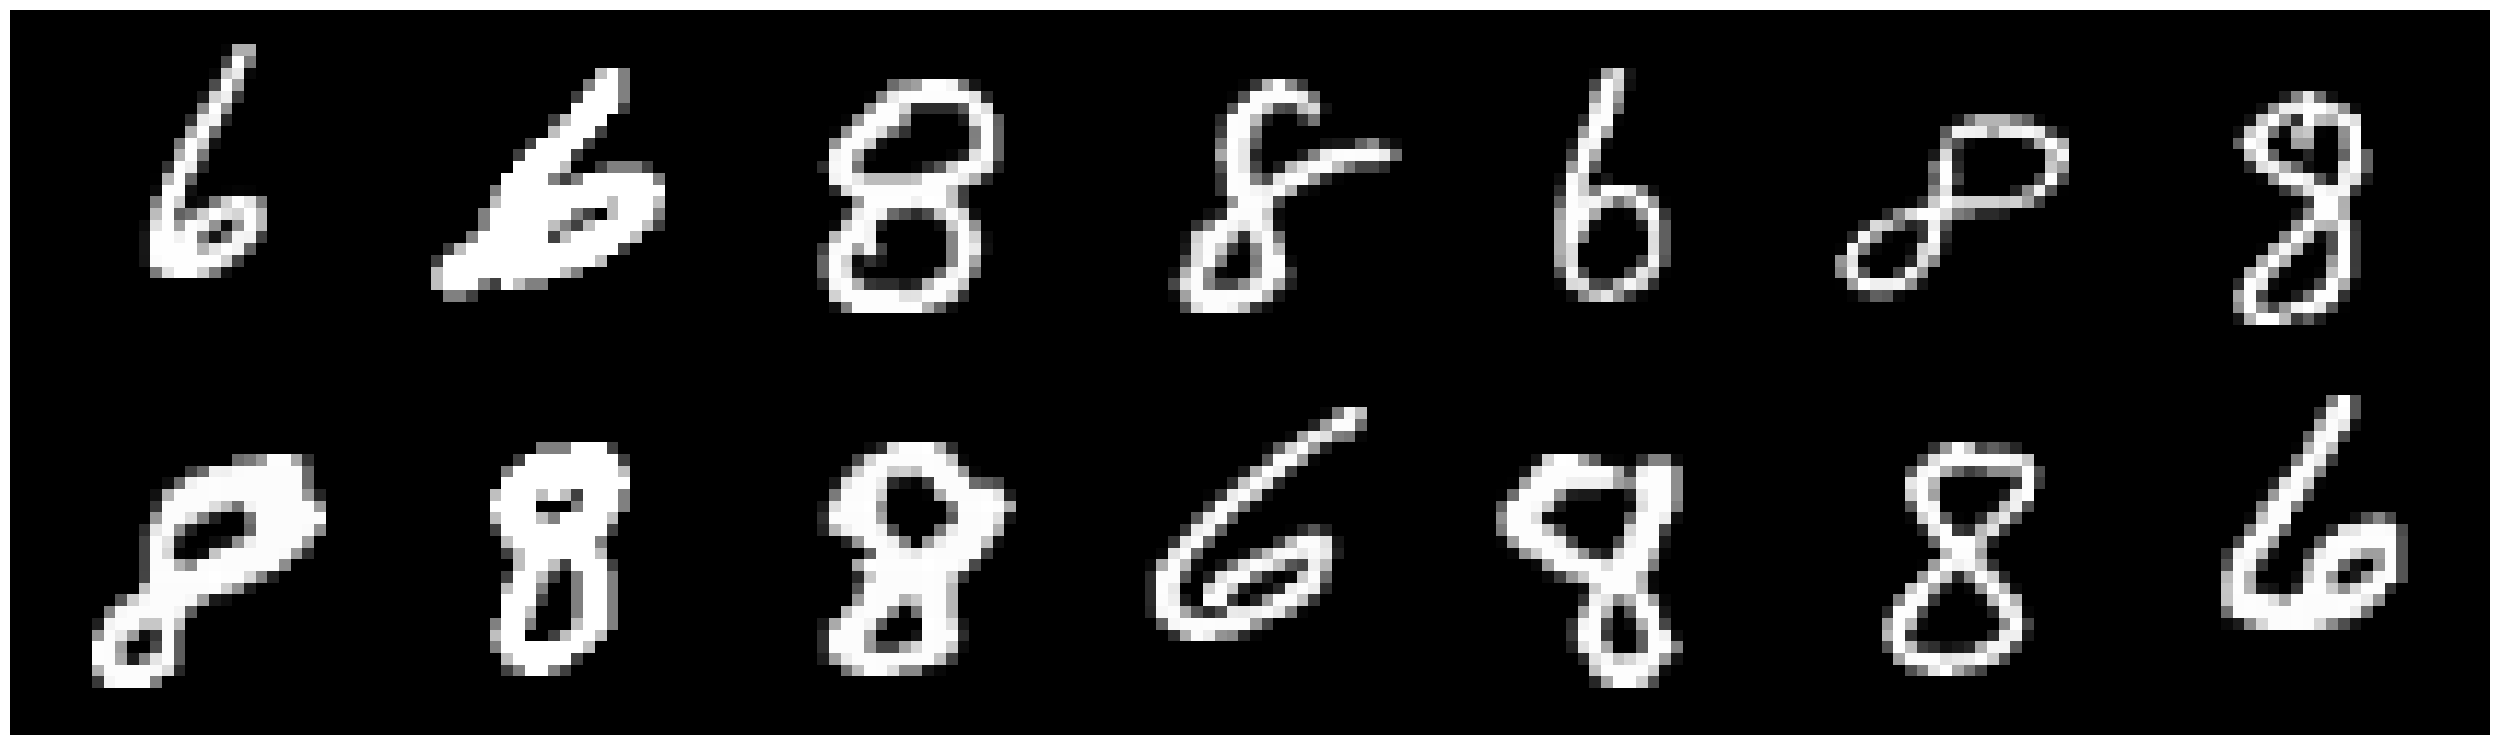

In [21]:
random_sel = np.random.randint(n_train, size=14)
ten = range(10)

dispImage(train_df, random_sel)
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

## Distribution of the Classes among Datasets

Shape of the train_df is:  (8200, 785)
Shape of the test_df is:  (5368, 785)


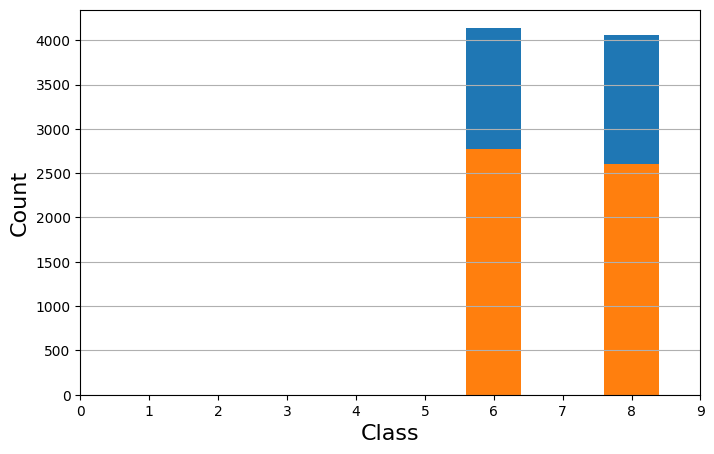

In [22]:
def showHistogram(df):
    plt.rcParams['figure.figsize'] = (8, 5)
    plt.bar(df['label'].value_counts().index, df['label'].value_counts())
    plt.xticks(np.arange(10))
    plt.xlabel('Class', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.grid('on', axis='y')

showHistogram(train_df) # Blue si train
showHistogram(test_df) # Orange is test
print("Shape of the train_df is: ", train_df.shape)
print("Shape of the test_df is: ", test_df.shape)

## Dataloader Class Definiton

In [23]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    
    
    def __init__(self, 
                 df_, #file_path, 
                 sep=',', 
                 isTest=False,
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = df_ #pd.read_csv(file_path, sep=sep)
        self.df = df_
        
        if isTest:
            # test data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def get_labels(self):
        return df.iloc[:,0]

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

## Random Rotation

In [24]:
class RandomRotation(object):
    """
    https://github.com/pytorch/vision/tree/master/torchvision/transforms
    Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        
        def rotate(img, angle, resample=False, expand=False, center=None):
            """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
            Args:
            img (PIL Image): PIL Image to be rotated.
            angle ({float, int}): In degrees degrees counter clockwise order.
            resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
            center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
            """
                
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

## Random Shift

In [25]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
    

## Define the Datasets and Dataloaders

In [26]:
batch_size = 64

train_dataset = MNIST_data(train_df, transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)




test_dataset = MNIST_data(test_df, sep=';', isTest=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

train_x_dataset = MNIST_data(train_df, isTest=True)
train_x_loader = torch.utils.data.DataLoader(dataset=train_x_dataset, batch_size=batch_size, shuffle=False)


test_y_dataset = MNIST_data(test_df, sep=';')
test_y_loader = torch.utils.data.DataLoader(dataset=test_y_dataset, batch_size=batch_size, shuffle=True)


8, 6, 6, 6, 8, 8, 6, 8, 6, 6, 6, 8, 6, 8
8, 6, 6, 6, 8, 8, 6, 8, 6, 6, 6, 8, 6, 8


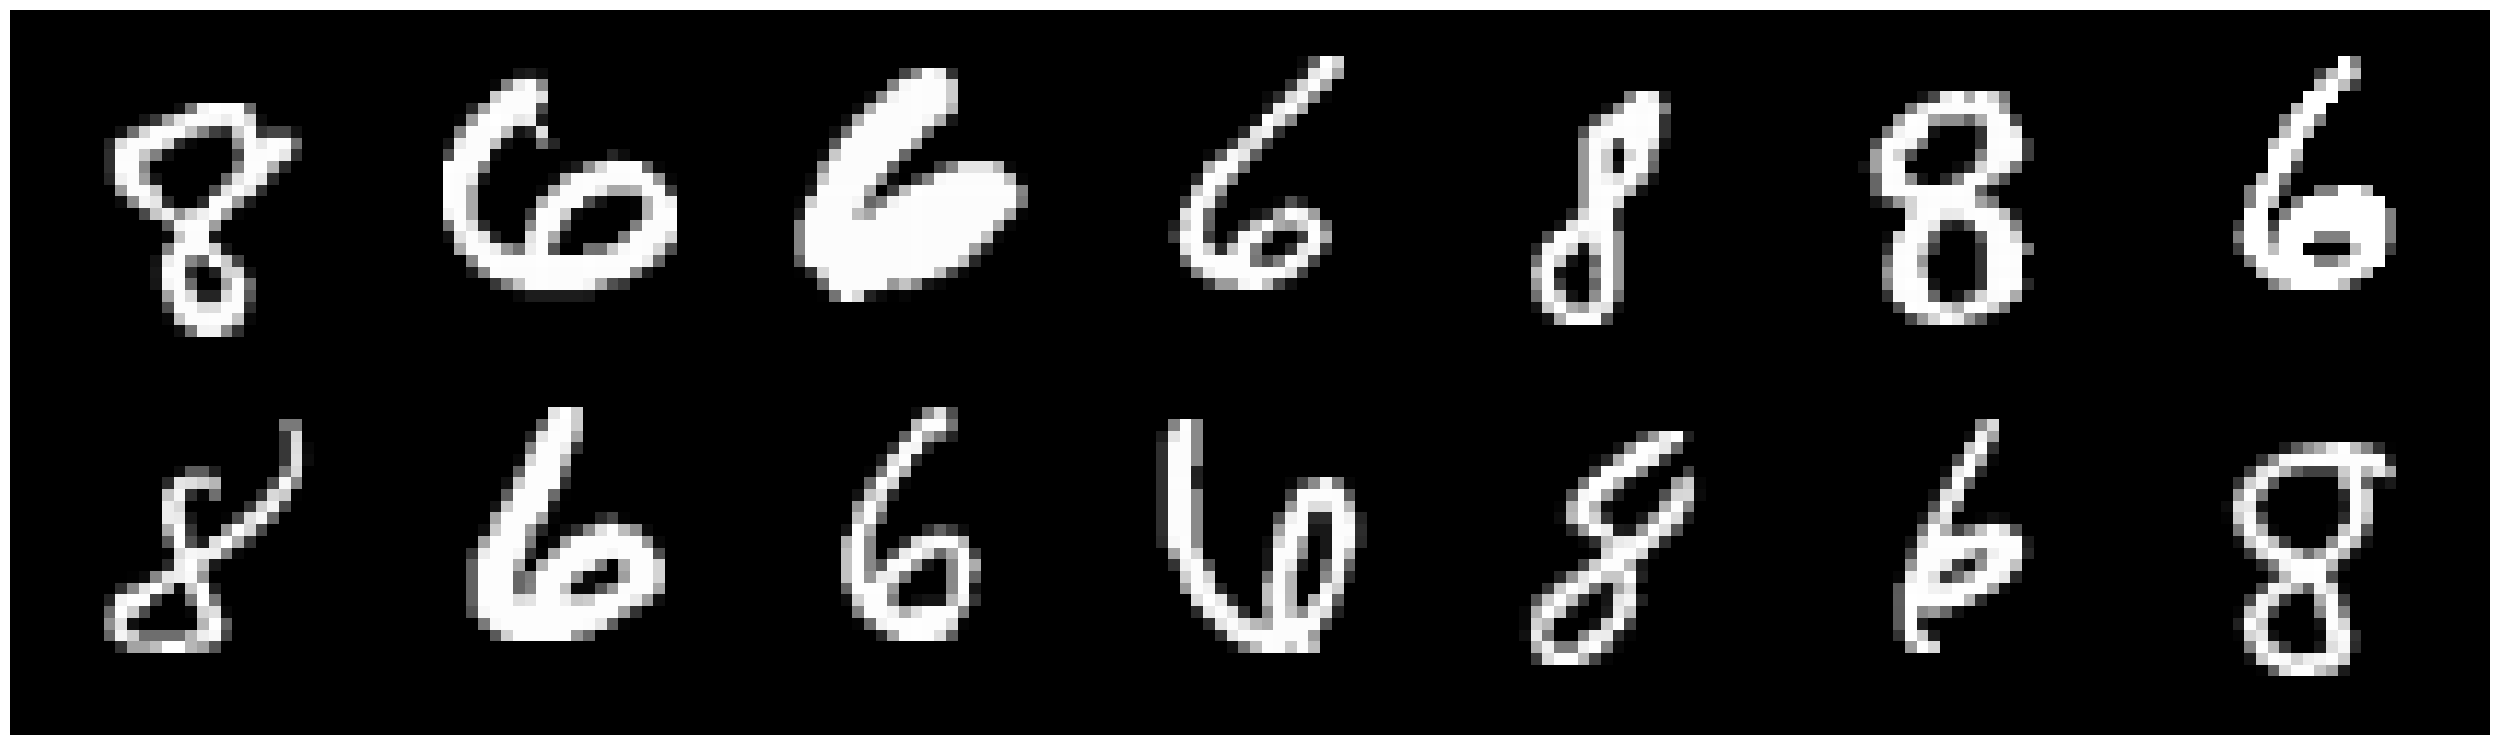

In [27]:
dispImage(train_df, np.arange(14))
    
print(*list(train_df.iloc[:14, 0].values), sep = ', ')
print(*list(train_dataset.df.iloc[:14,0].values), sep = ', ')

## Demonstration of Random Rotation & Shift

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_22191/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_22191/2105636642.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)


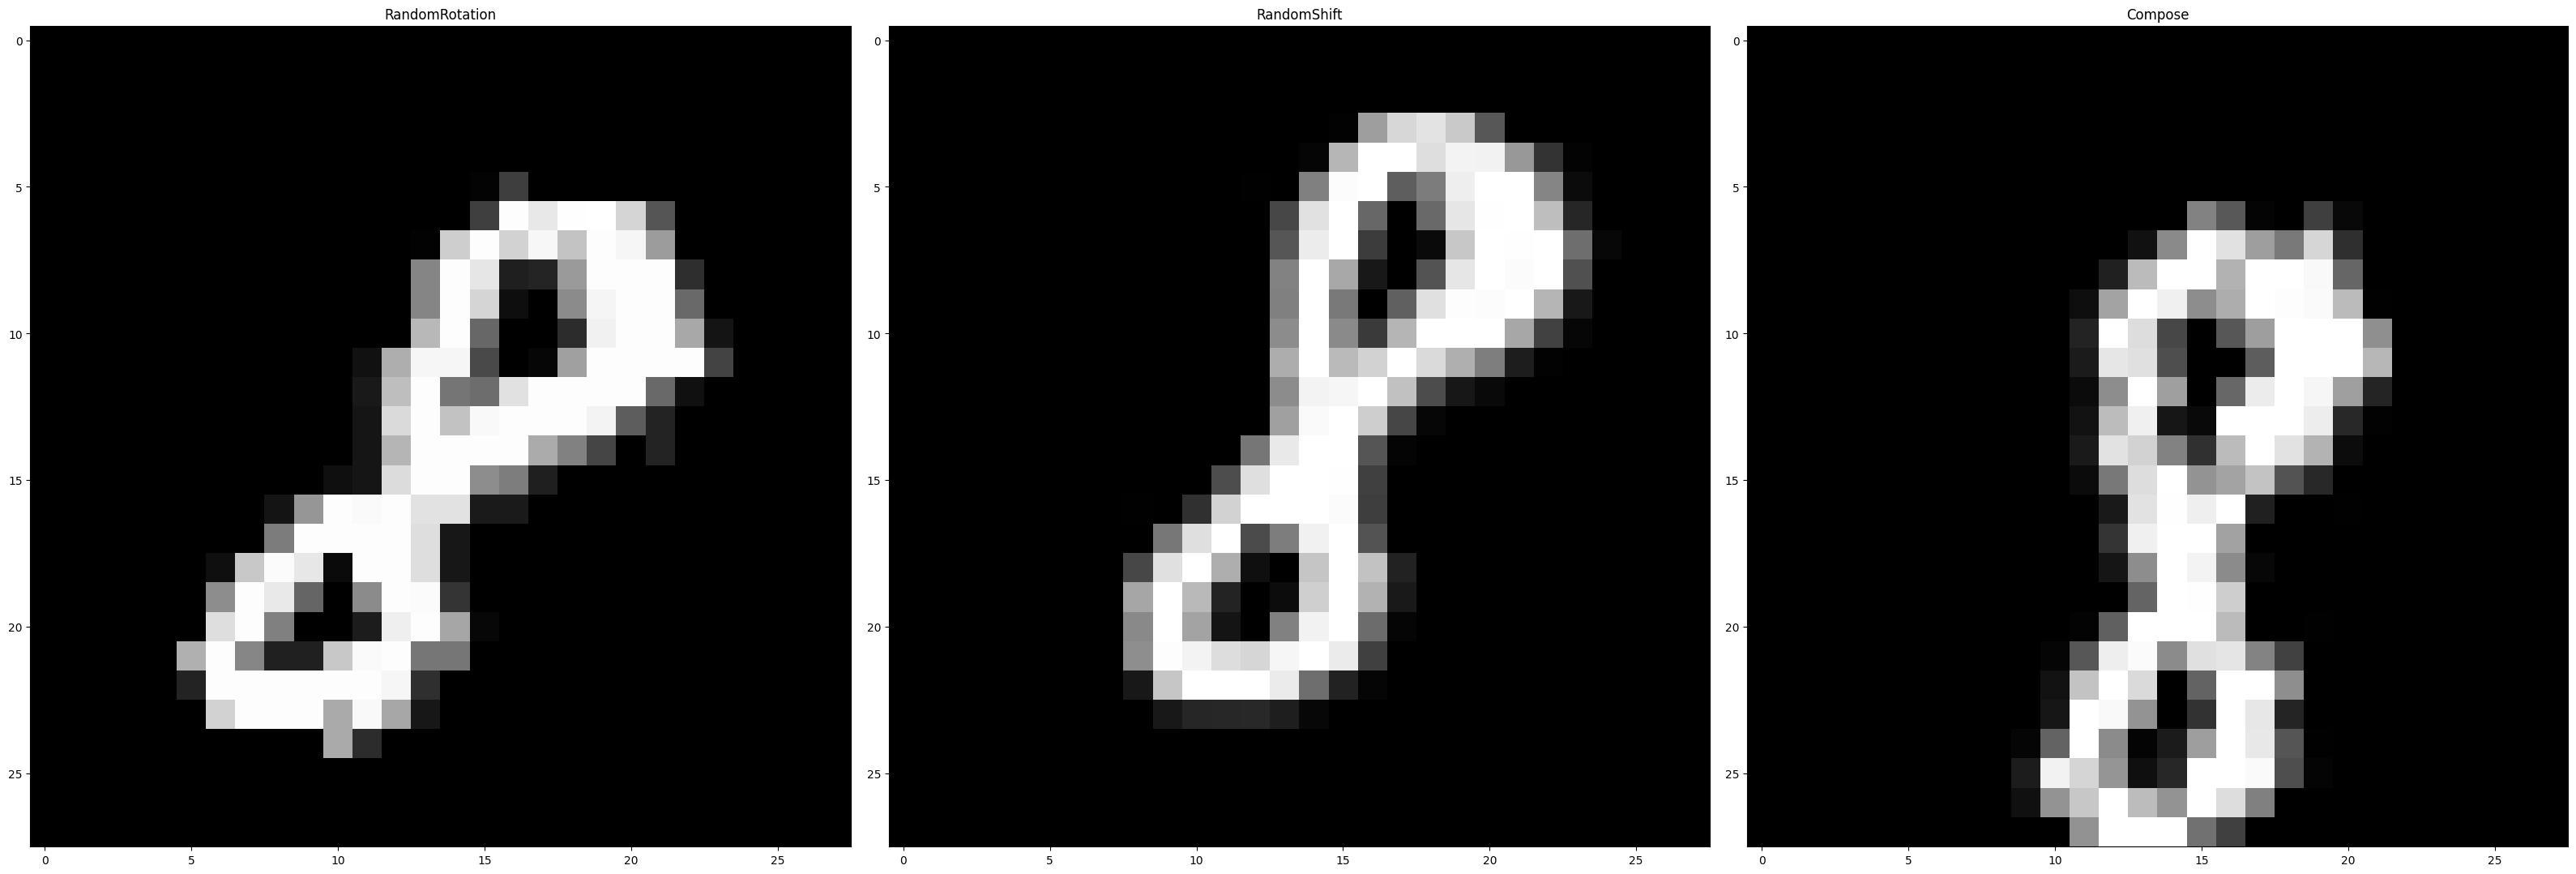

In [28]:
rotate = RandomRotation(20)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(20),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(train_df.iloc[65,1:].values.reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

## Define the Neural Network

In [29]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

## Initialize the Model

In [30]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003) #0.003

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_22191/4122321177.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


## Training Algorithm

In [31]:
loss_values = []
def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        val = F.cross_entropy(output, target, size_average=False).data
        loss_values.append(val)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
    
    
    exp_lr_scheduler.step()

## Evaluation of Training

In [32]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

## Train the Model

In [33]:
n_epochs = 1

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_22191/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_22191/2105636642.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/Users/ilerisoy/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [640/8200 (8%)]	Loss: 0.237823
Train Epoch: 0 [1280/8200 (16%)]	Loss: 0.549123
Train Epoch: 0 [1920/8200 (23%)]	Loss: 0.253397
Train Epoch: 0 [2560/8200 (31%)]	Loss: 0.037551
Train Epoch: 0 [3200/8200 (39%)]	Loss: 0.061033
Train Epoch: 0 [3840/8200 (47%)]	Loss: 0.177926
Train Epoch: 0 [4480/8200 (54%)]	Loss: 0.028353
Train Epoch: 0 [5120/8200 (62%)]	Loss: 0.044719
Train Epoch: 0 [5760/8200 (70%)]	Loss: 0.007417
Train Epoch: 0 [6400/8200 (78%)]	Loss: 0.123368
Train Epoch: 0 [7040/8200 (85%)]	Loss: 0.147908
Train Epoch: 0 [7680/8200 (93%)]	Loss: 0.047153

Average loss: 0.0295, Accuracy: 8118/8200 (99.000%)



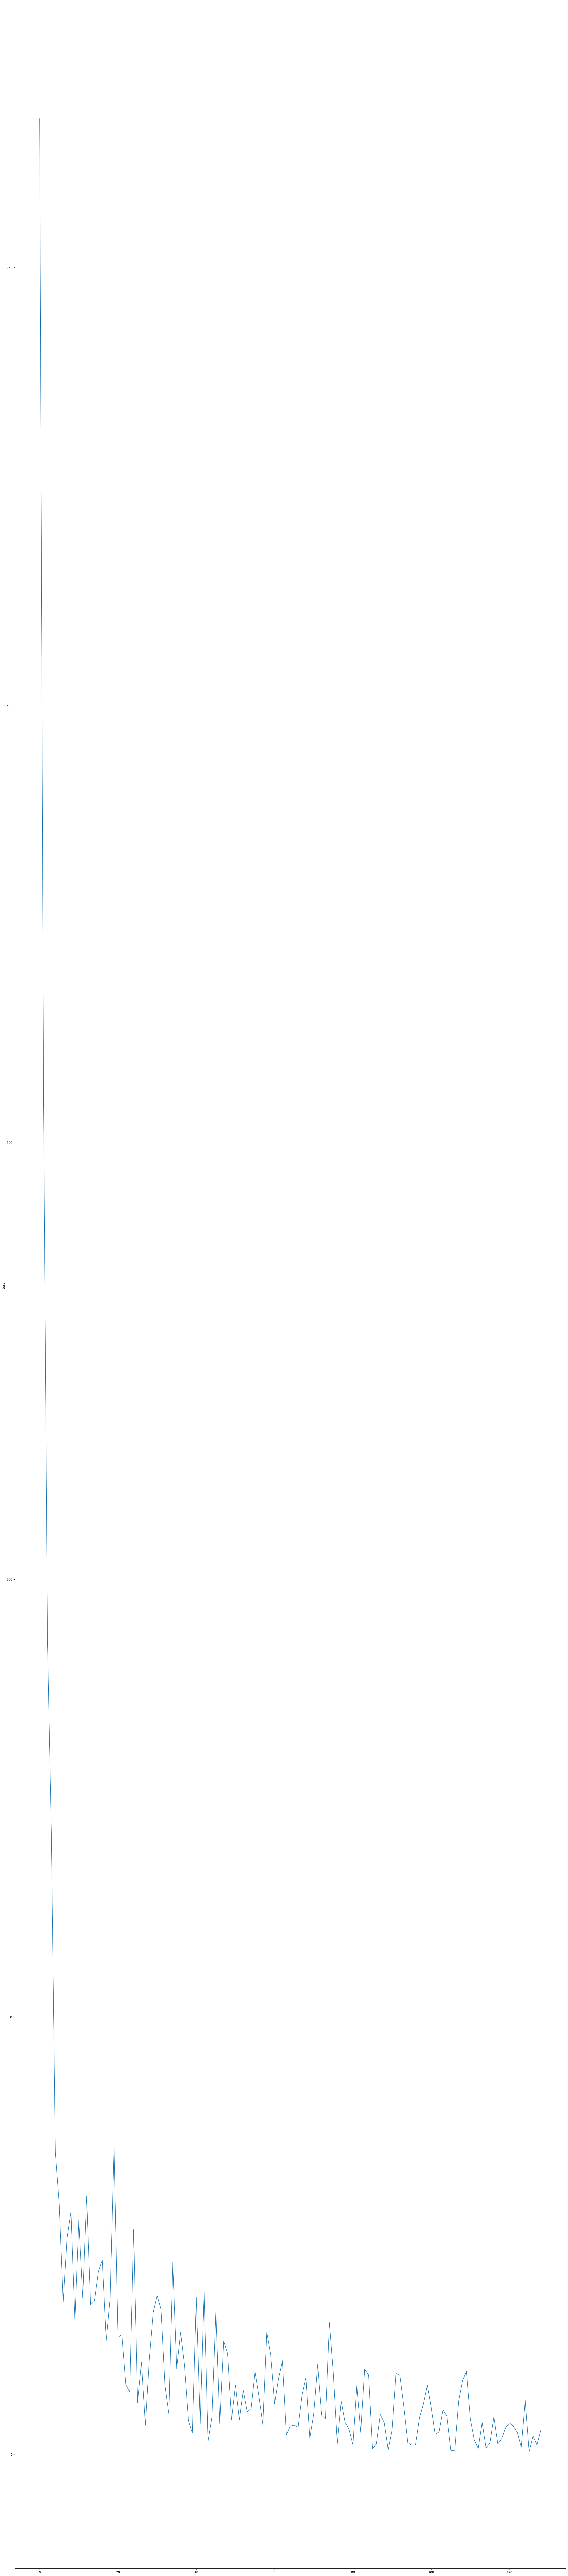

[tensor(266.9971), tensor(154.4011), tensor(93.1002), tensor(70.7047), tensor(34.5611)] [tensor(6.1858), tensor(0.2678), tensor(2.0936), tensor(1.0609), tensor(2.7544)]
129


In [34]:
plt.plot(loss_values)
plt.ylabel('Loss')
plt.show()

print(loss_values[0:5], loss_values[len(loss_values)-5:])
print(len(loss_values))

## Prediction Algorithm

In [35]:
train_prob = []
test_prob = []
def prediciton(data_loader, df_type):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        batch_prob = F.softmax(output, dim=1)
        if df_type == "train":
            for i in range(len(batch_prob)):
                train_prob.append(batch_prob[i])
        elif df_type == "test":
            for i in range(len(batch_prob)):
                test_prob.append(batch_prob[i])
        else:
            print("Wrong df type is given...")
            return 0
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [36]:
train_pred = prediciton(train_x_loader, "train")

In [37]:
test_pred = prediciton(test_loader, "test")

## Function to Get the Confidence Values

In [38]:
def getProbs(rawProbs):
    temp = []
    
    for i in range(len(rawProbs)):
        temp.append(rawProbs[i].detach().numpy())

    return temp

train_probs = getProbs(train_prob)
test_probs = getProbs(test_prob)

In [39]:
item = 0
print(train_probs[item][class1])
print(test_probs[item][class1])

1.0269566e-08
8.0756976e-08


# Training Prediction

In [40]:
train_prediction_df = pd.DataFrame(np.c_[np.arange(1, len(train_dataset)+1)[:,None], train_pred.numpy()], 
                      columns=['ImageId', 'Label'])

# Make a numpay array by predcited labels
train_predictions = train_prediction_df.iloc[:,1].to_numpy()
train_labels = train_df.iloc[:,0].to_numpy()
print(len(train_predictions), train_predictions[:10], train_labels[:10])

8200 [8 6 6 6 8 8 6 8 6 6] [8 6 6 6 8 8 6 8 6 6]


In [41]:
train_predictions = train_prediction_df.iloc[:, 1].to_numpy()

count = 0
train_index = []

for i in range(len(train_predictions)):
    if train_dataset.df.iloc[i,0] == train_predictions[i]:
        continue
    else:
        count +=1
        train_index.append(i)
        print("Label is: ", train_dataset.y.numpy()[i], "Predcition is: ", train_predictions[i], "index is: ", i)
print(count)

Label is:  8 Predcition is:  6 index is:  323
Label is:  8 Predcition is:  6 index is:  498
Label is:  6 Predcition is:  8 index is:  948
Label is:  8 Predcition is:  6 index is:  1077
Label is:  8 Predcition is:  6 index is:  1278
Label is:  8 Predcition is:  6 index is:  1488
Label is:  6 Predcition is:  8 index is:  1583
Label is:  8 Predcition is:  6 index is:  1971
Label is:  8 Predcition is:  6 index is:  2091
Label is:  8 Predcition is:  6 index is:  2189
Label is:  8 Predcition is:  6 index is:  2290
Label is:  6 Predcition is:  8 index is:  2596
Label is:  8 Predcition is:  6 index is:  2614
Label is:  8 Predcition is:  6 index is:  2716
Label is:  8 Predcition is:  6 index is:  3153
Label is:  8 Predcition is:  6 index is:  3213
Label is:  8 Predcition is:  6 index is:  3812
Label is:  8 Predcition is:  6 index is:  3900
Label is:  6 Predcition is:  8 index is:  4309
Label is:  8 Predcition is:  6 index is:  4390
Label is:  8 Predcition is:  6 index is:  4505
Label is:  8 Pre

In [42]:
con_train = confusion_matrix(train_dataset.df.iloc[:,0], train_predictions)
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
# true label being i-th class and predicted label being j-th class.
print("\nConfusion Matrix is:\n")
print(con_train,"\n")


# Class 0 is treated as Negative
tn, fp, fn, tp = con_train.ravel()

prec_test = tp/(tp+fp)
sens = tp/(tp+fn)
spec = tn/(tn+fp)

total = tp+tn+fn+fp
acc = (tp+tn)*100/total
print("Accuracy is: %", acc)

print("\nPrecision is: ", prec_test)

print("Sensitivity is: ", sens)
print("Specificity is: ", spec)


print("\nTP: ", tp, "FP: ", fp)
print("FN: ", fn, "  TN: ", tn)


Confusion Matrix is:

[[4127   10]
 [  28 4035]] 

Accuracy is: % 99.53658536585365

Precision is:  0.9975278121137207
Sensitivity is:  0.9931085404873247
Specificity is:  0.997582789460962

TP:  4035 FP:  10
FN:  28   TN:  4127


Image :  0
Confidance values are :  0.9690578 0.027662124
Ground Truth is:  8
Predicted as:  6
Image :  1
Confidance values are :  0.9498106 0.045634896
Ground Truth is:  8
Predicted as:  6
Image :  2
Confidance values are :  0.17807716 0.8097875
Ground Truth is:  6
Predicted as:  8
Image :  3
Confidance values are :  0.872859 0.115700714
Ground Truth is:  8
Predicted as:  6
Image :  4
Confidance values are :  0.6304236 0.3525524
Ground Truth is:  8
Predicted as:  6
Image :  5
Confidance values are :  0.64747596 0.3273448
Ground Truth is:  8
Predicted as:  6
Image :  6
Confidance values are :  0.2932172 0.69949204
Ground Truth is:  6
Predicted as:  8
Image :  7
Confidance values are :  0.5913745 0.40475026
Ground Truth is:  8
Predicted as:  6
Image :  8
Confidance values are :  0.88799345 0.10222085
Ground Truth is:  8
Predicted as:  6
Image :  9
Confidance values are :  0.63594663 0.3554192
Ground Truth is:  8
Predicted as:  6
Image :  10
Confidance values are :  0.9351637 0.060196318

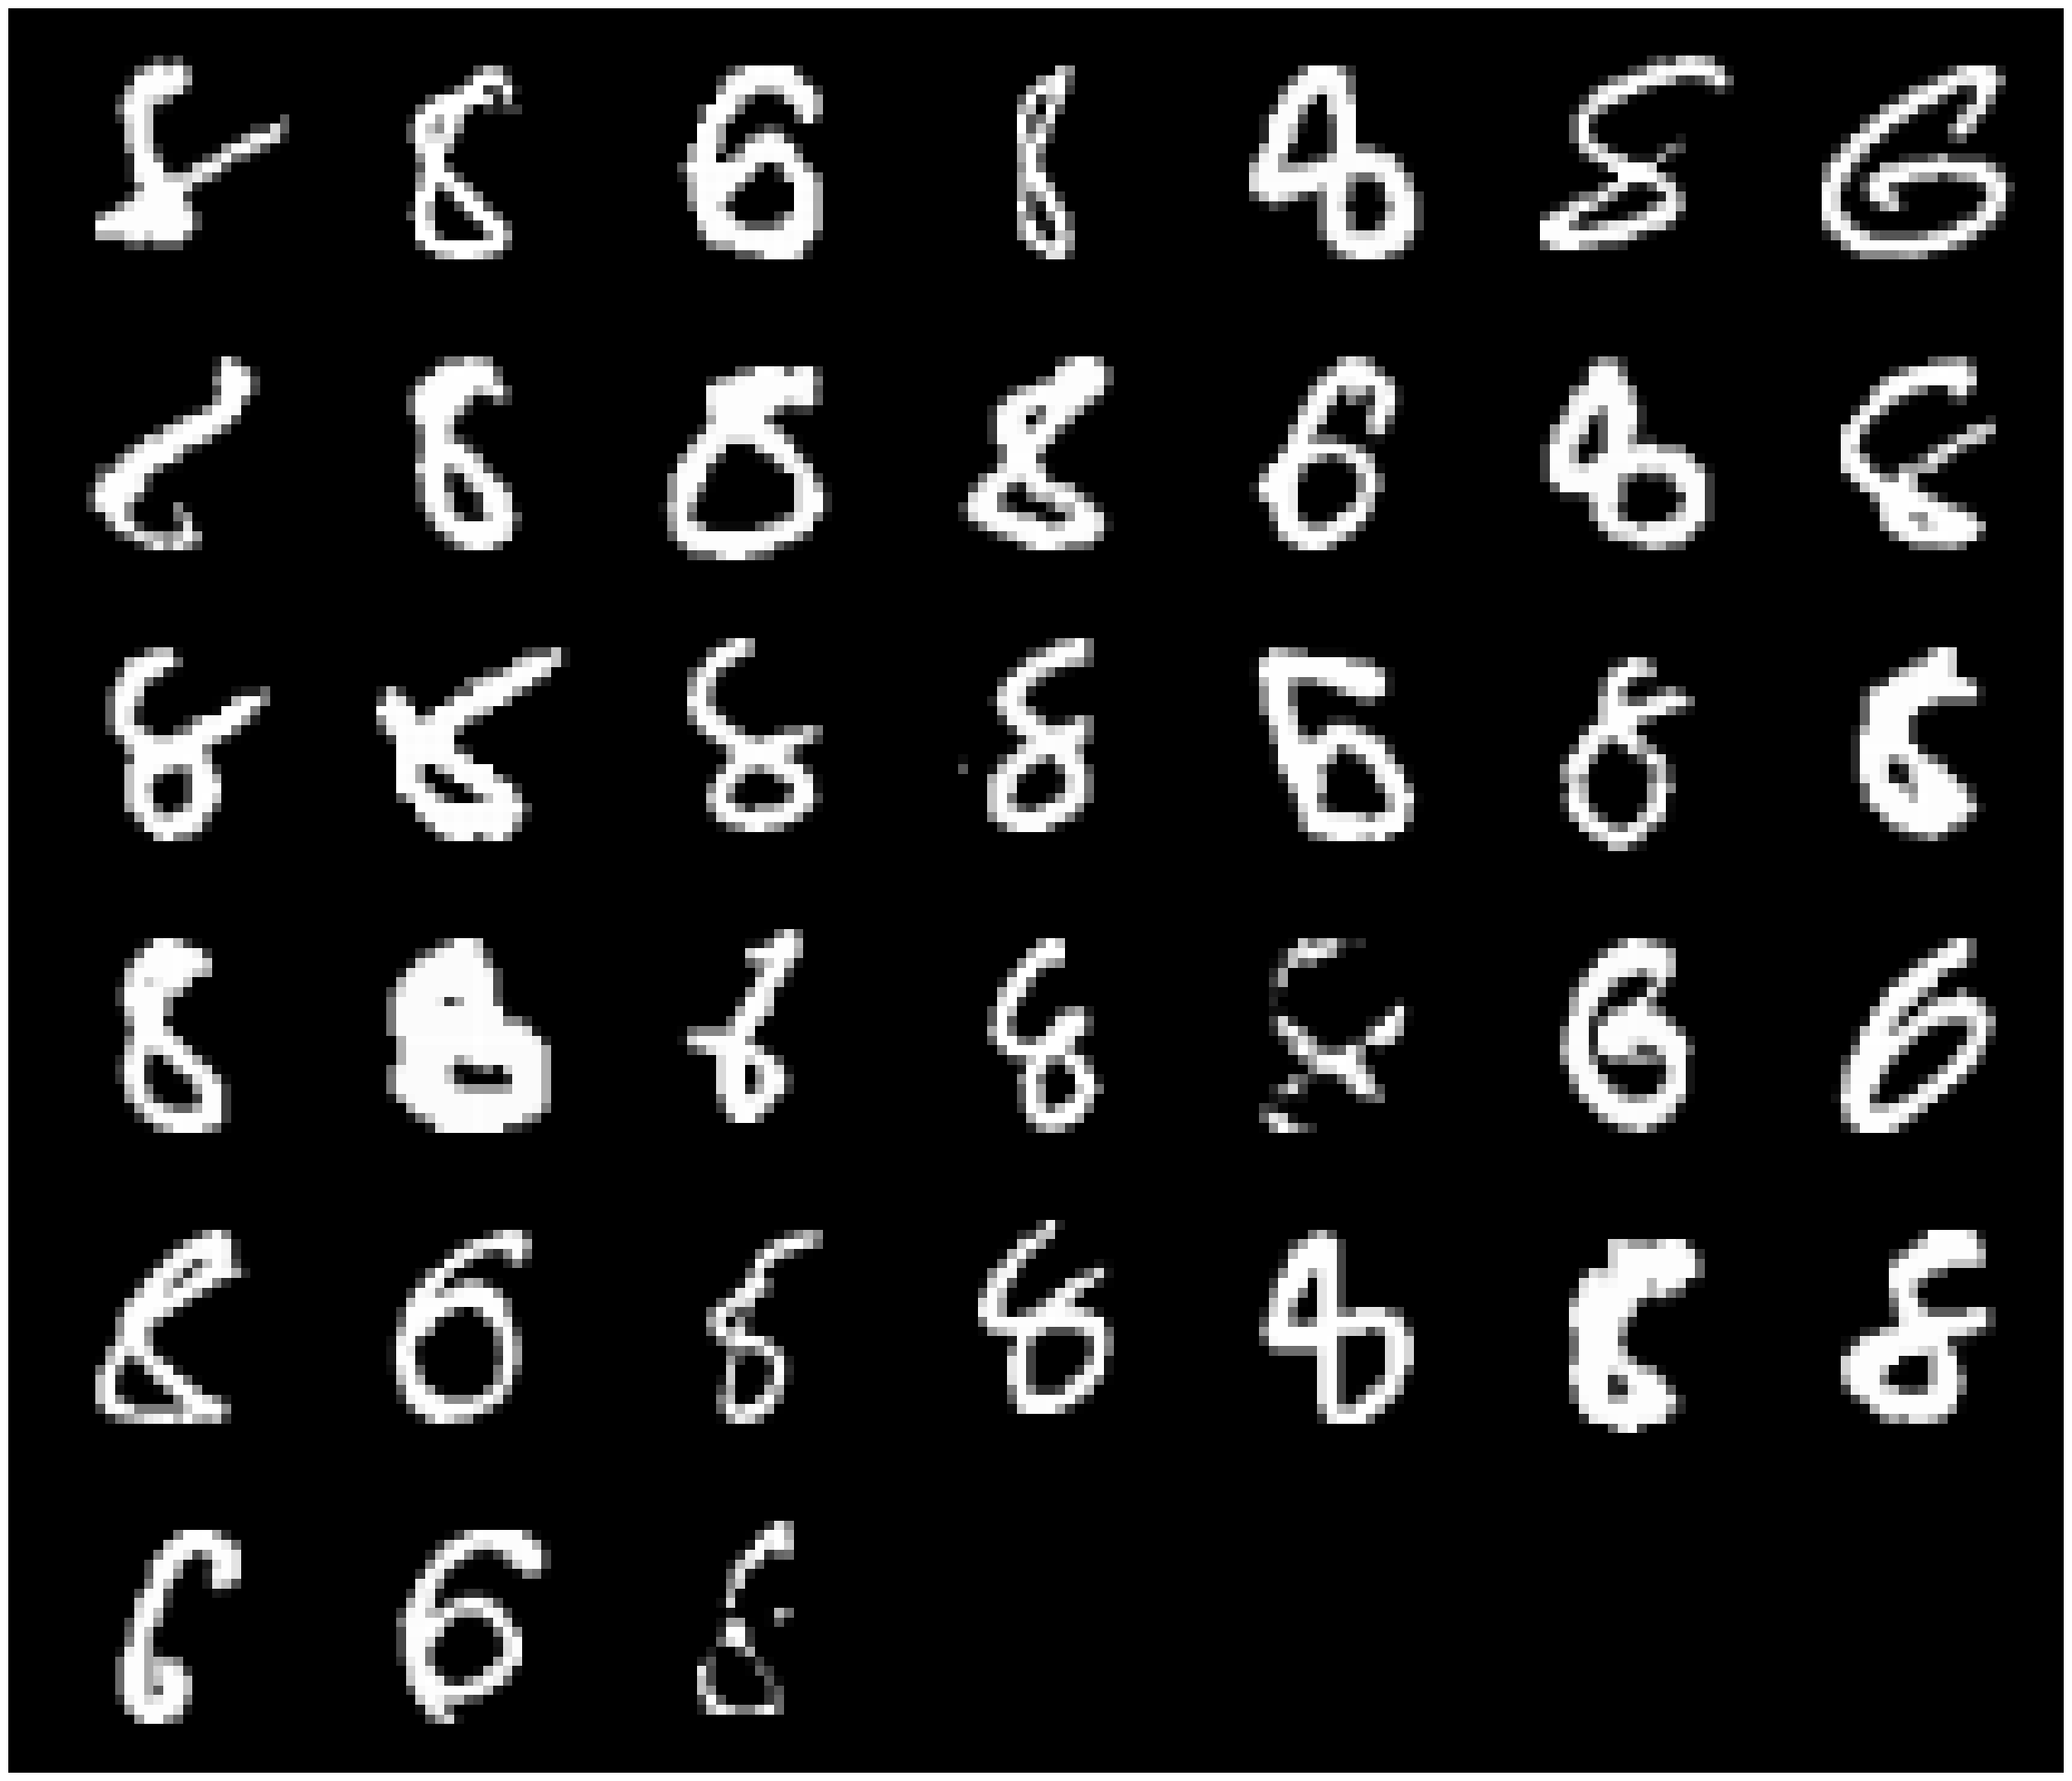

In [44]:
sel = count

for i in range(sel):
    print("Image : ", i)
    print("Confidance values are : ", train_probs[train_index[i]][class1], train_probs[train_index[i]][class2])
    print("Ground Truth is: ", train_df.iloc[train_index[i],0])
    print("Predicted as: ", train_predictions[train_index[i]])

dispImage(train_df, train_index[:sel])

# Test Prediction

In [45]:
test_pred_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [46]:
test_prediction_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

# Make a numpay array by predcited labels
test_predictions = test_prediction_df.iloc[:,1].to_numpy()
test_labels = test_y_dataset.df.iloc[:,0].to_numpy()
print(len(test_predictions), test_predictions[:10], test_labels[:10])

5368 [8 6 8 8 6 6 8 8 8 6] [8 6 8 8 6 6 8 8 8 6]


In [47]:
test_predictions = test_prediction_df.iloc[:, 1].to_numpy()

count2 = 0
test_index = []

for i in range(len(test_predictions)):
    if test_y_dataset.df.iloc[i,0] == test_predictions[i]:
        continue
    else:
        count2 +=1
        test_index.append(i)
        print("Label is: ", test_y_dataset.y.numpy()[i], "Predcition is: ", test_predictions[i], "index is: ", i)
print(count2)

Label is:  6 Predcition is:  8 index is:  90
Label is:  8 Predcition is:  6 index is:  428
Label is:  8 Predcition is:  6 index is:  520
Label is:  8 Predcition is:  6 index is:  736
Label is:  6 Predcition is:  8 index is:  928
Label is:  6 Predcition is:  8 index is:  1139
Label is:  6 Predcition is:  8 index is:  1181
Label is:  6 Predcition is:  8 index is:  1259
Label is:  6 Predcition is:  8 index is:  1381
Label is:  8 Predcition is:  6 index is:  1843
Label is:  8 Predcition is:  6 index is:  1866
Label is:  8 Predcition is:  6 index is:  2045
Label is:  8 Predcition is:  6 index is:  2086
Label is:  8 Predcition is:  6 index is:  2250
Label is:  6 Predcition is:  8 index is:  2393
Label is:  6 Predcition is:  8 index is:  2568
Label is:  6 Predcition is:  8 index is:  2732
Label is:  6 Predcition is:  8 index is:  2740
Label is:  6 Predcition is:  8 index is:  2802
Label is:  6 Predcition is:  8 index is:  2860
Label is:  8 Predcition is:  6 index is:  3352
Label is:  6 Predci

In [48]:
test_predictions = test_pred_df.iloc[:, 1].to_numpy()
con_test = confusion_matrix(test_dataset.df.iloc[:,0], test_predictions)
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
# true label being i-th class and predicted label being j-th class.
print("\nConfusion Matrix is:\n")
print(con_test,"\n")


# Class 0 is treated as Negative
tn, fp, fn, tp = con_test.ravel()

prec_test = tp/(tp+fp)
sens = tp/(tp+fn)
spec = tn/(tn+fp)

total = tp+tn+fn+fp
acc = (tp+tn)*100/total
print("Accuracy is: %", acc)

print("\nPrecision is: ", prec_test)

print("Sensitivity is: ", sens)
print("Specificity is: ", spec)


print("\nTP: ", tp, "FP: ", fp)
print("FN: ", fn, "  TN: ", tn)


Confusion Matrix is:

[[2749   18]
 [  12 2589]] 

Accuracy is: % 99.44113263785395

Precision is:  0.9930955120828538
Sensitivity is:  0.9953863898500577
Specificity is:  0.9934947596675099

TP:  2589 FP:  18
FN:  12   TN:  2749


Image :  0
Confidance values are :  0.32850242 0.66010284
Ground Truth is:  6
Predicted as:  8
Image :  1
Confidance values are :  0.8148915 0.1706243
Ground Truth is:  8
Predicted as:  6
Image :  2
Confidance values are :  0.73905295 0.2530128
Ground Truth is:  8
Predicted as:  6
Image :  3
Confidance values are :  0.58844244 0.4002723
Ground Truth is:  8
Predicted as:  6
Image :  4
Confidance values are :  0.042241238 0.95206356
Ground Truth is:  6
Predicted as:  8
Image :  5
Confidance values are :  0.004811264 0.994803
Ground Truth is:  6
Predicted as:  8
Image :  6
Confidance values are :  0.38911092 0.5776025
Ground Truth is:  6
Predicted as:  8
Image :  7
Confidance values are :  0.118357845 0.8718972
Ground Truth is:  6
Predicted as:  8
Image :  8
Confidance values are :  0.19582683 0.7872313
Ground Truth is:  6
Predicted as:  8
Image :  9
Confidance values are :  0.87260675 0.11552556
Ground Truth is:  8
Predicted as:  6
Image :  10
Confidance values are :  0.875733 0.11630551

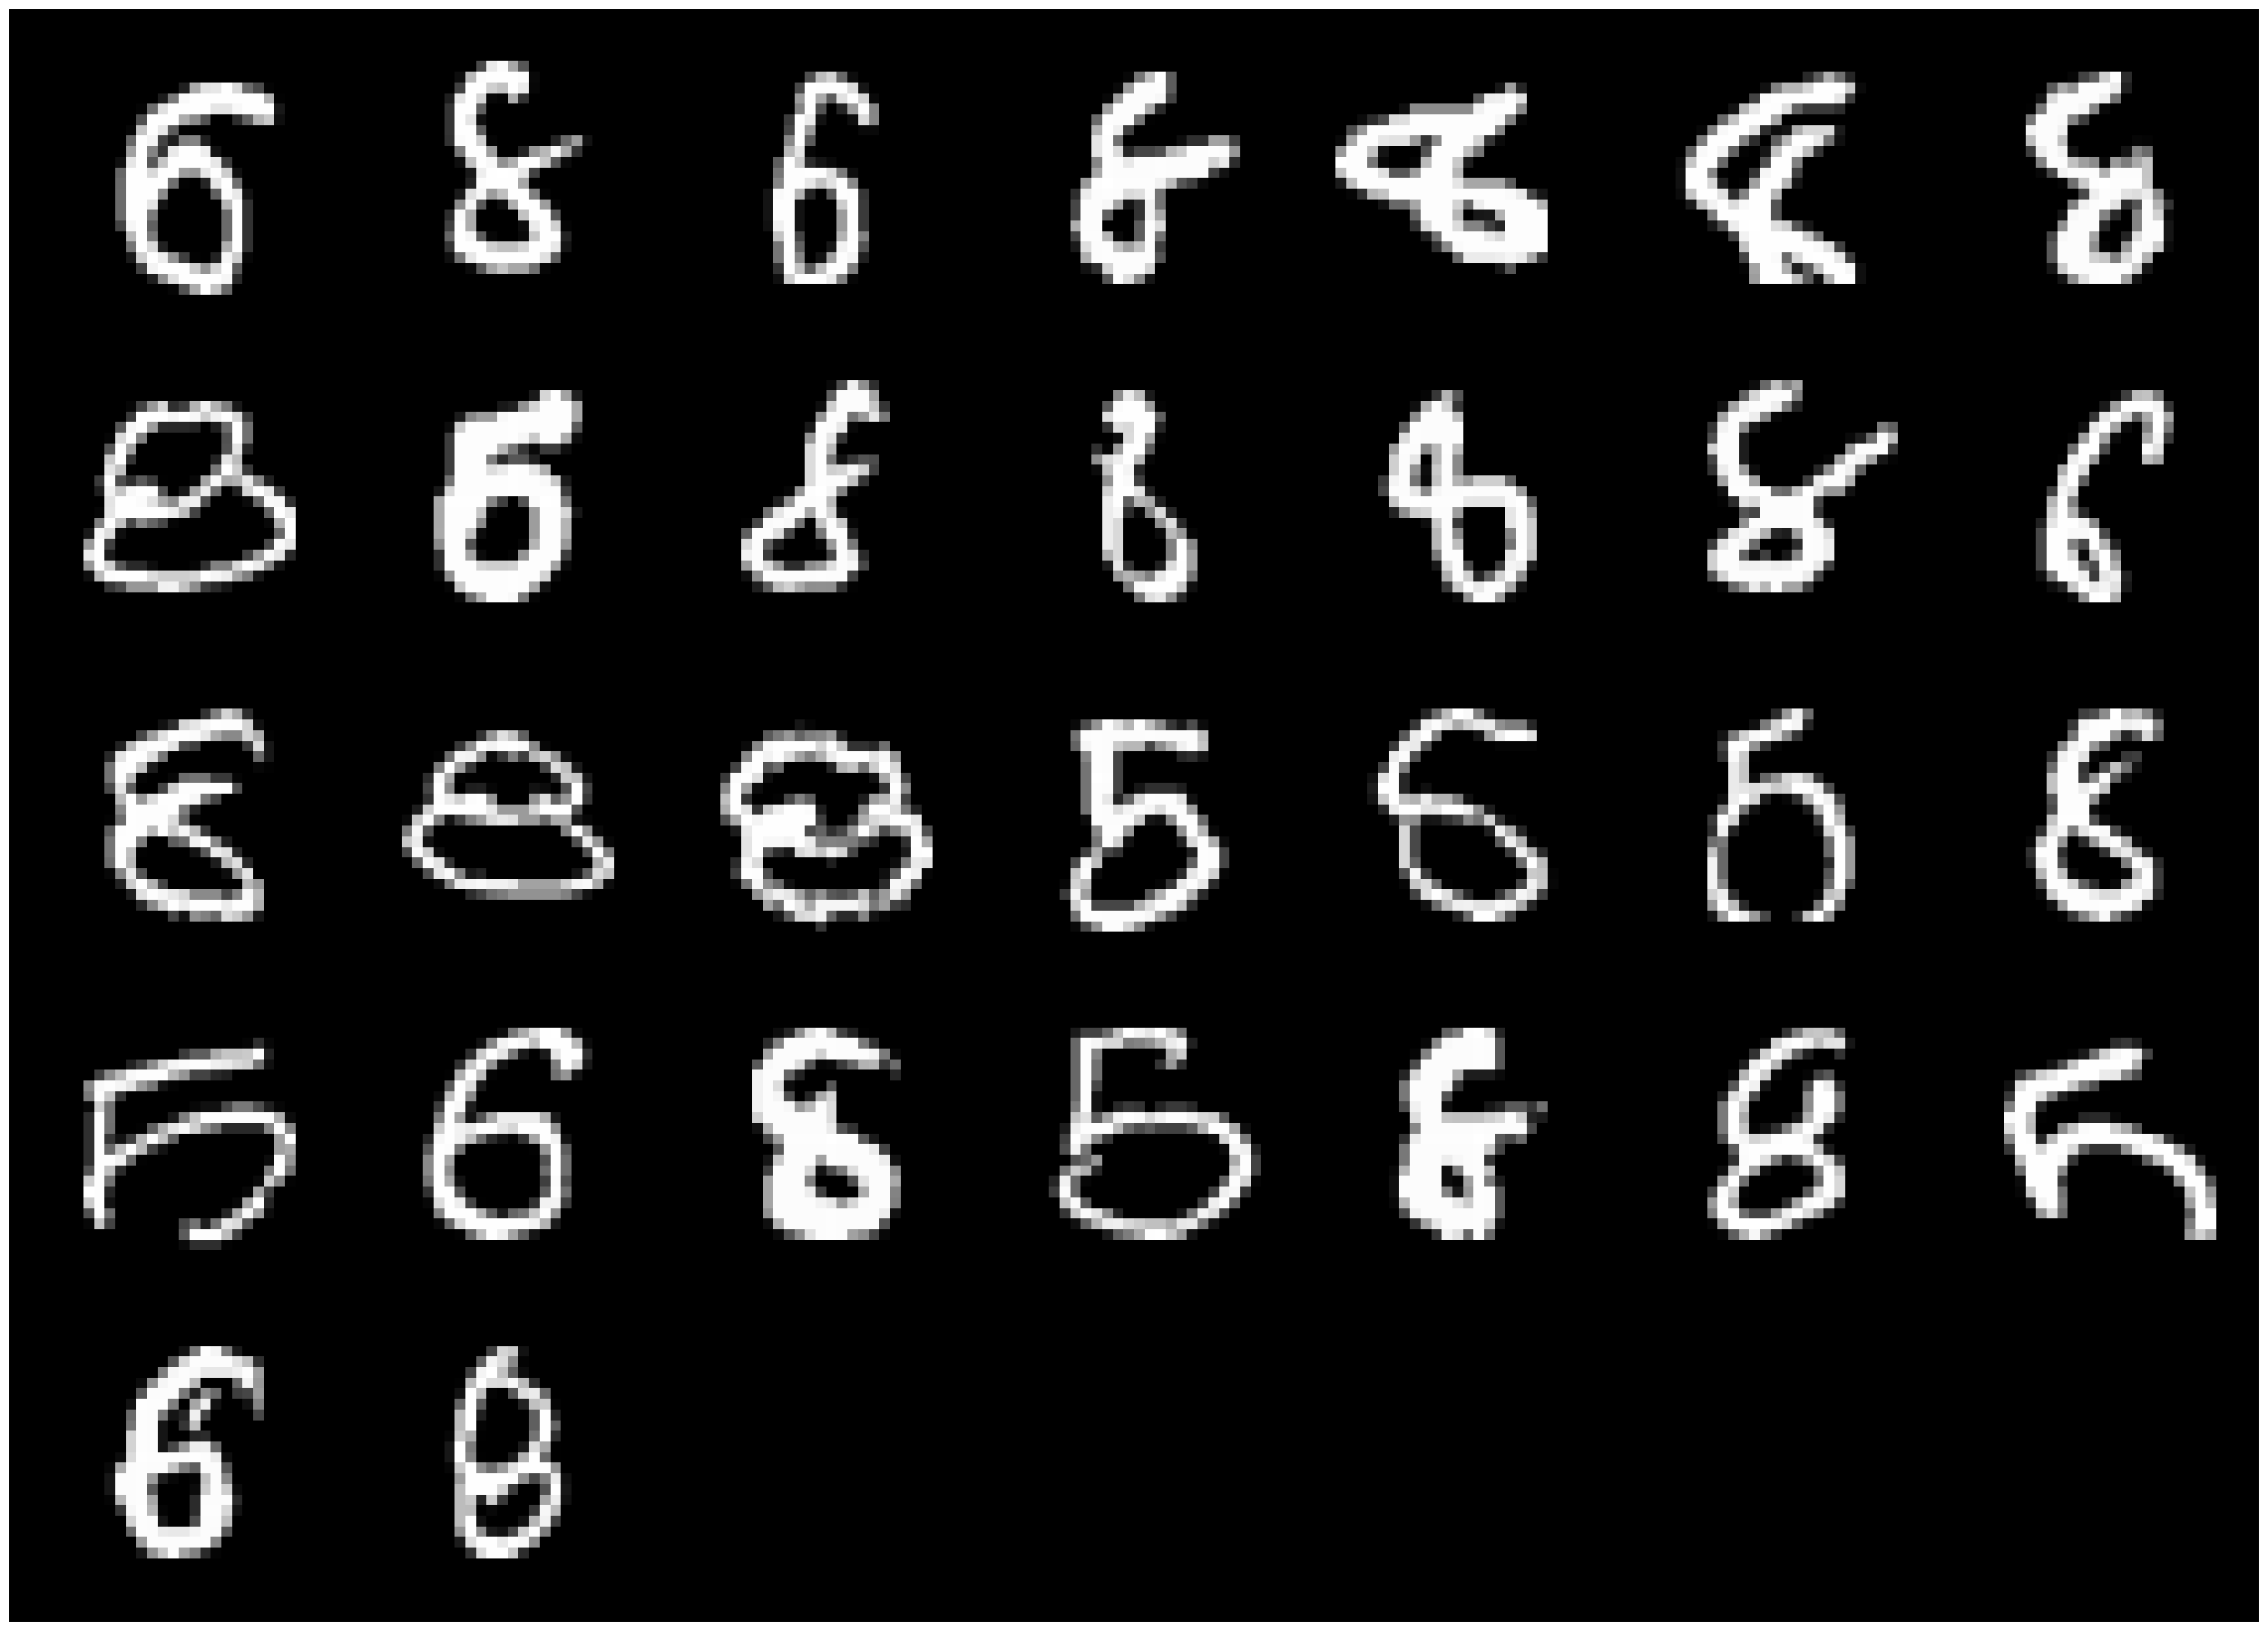

In [50]:
sel2 = count2

for i in range(sel2):
    print("Image : ", i)
    print("Confidance values are : ", test_probs[test_index[i]][class1], test_probs[test_index[i]][class2])
    print("Ground Truth is: ", test_df.iloc[test_index[i],0])
    print("Predicted as: ", test_predictions[test_index[i]])

dispImage(test_df, test_index[:sel2])

In [ ]:
npv = tn/(tn+fn)
print(npv)